# Applied Data Science Capstone Final Project Week 2

### By Ruslan Ikhsanov

##### "Welcome everyone, this has been long and tough path, but I am happy to pass all the assignments, wish everyone who visited this notebook all the best!"

__Table of Contents__

<font color=blue>1. Introduction</font>

<font color=blue>2. Describing the data</font>

<font color=blue>3. Methodology</font>

<font color=blue>4. Results section</font>

<font color=blue>5. Discussion</font>

<font color=blue>6. Conclusion</font>




### Introduction

"London is the capital of Great Britain" - one of the first sentences we have been taught at school. London is a great city, with rich history, holding huge number of different people of different races. London is one of central cities for tourism not only in Europe, but in the whole world. According to Wikipedia, nearly 20.5 million people visit London anually. This opens many opportunities for an enterpreneurs, which is in my imagination me planning to open East cousin restaraunt in London.

__Objective of the project__
<br> -  To analyze geographical data of London
<br> -  To use ML algorithm of K clustering to divide chosen area of London
<br> -  Identify cluster of area/district with the least number of East cousin restaraunts
<br> -  That will be answer to our question of finding location where openning of East restaraunt will be most suitable



### Describing the data

Data is taken from Wikipedia, link: https://en.wikipedia.org/wiki/List_of_areas_of_London

Data acquisition and preparation for further analysis will be presented during steps below:

##### Importing all the required modules and libraries

In [4]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [66]:
!pip -q install geopy

In [67]:
!pip -q install geocoder

In [5]:
from bs4 import BeautifulSoup

Extracting data from Wikipedia

In [6]:
website_url = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
tmp = requests.get(website_url).text
soup = BeautifulSoup(tmp,'lxml')
my_table = soup.find('table',{'class':'wikitable sortable'})

Creating empty DF

In [18]:
columns = ['Location', 'London Borough', 'Post Town', 'Postcode district', 'Dial code', 'OS grid ref']
# create the dataframe
df = pd.DataFrame(columns=columns)
df

,Location,London Borough,Post Town,Postcode district,Dial code,OS grid ref


Saving all rows content to the DF (dumping rows with borough = 'Not assigned')

In [19]:
for row in my_table.findAll("tr"):
    cells = row.findAll('td')
    if (len(cells) > 0):
        location = cells[0].find(text=True).lstrip('\n').strip()
        londonborough = cells[1].find(text=True).lstrip('\n').strip()
        posttown = cells[2].find(text=True).lstrip('\n').strip()
        postcodedistrict = cells[3].find(text=True).lstrip('\n').strip()
        dialcode = cells[4].find(text=True).lstrip('\n').strip()
        osgridref = cells[5].find(text=True).lstrip('\n').strip()
        if (londonborough != 'Not assigned'):
            if (posttown == 'Not assigned'):
                df = df.append({'Location': location,
                           'London Borough':londonborough,
                           'Post Town': posttown,
                           'Postcode district': postcodedistrict,
                           'Dial code': dialcode,
                           'OS grid ref': osgridref}, ignore_index=True)
            else:
                df = df.append({'Location': location,
                           'London Borough':londonborough,
                           'Post Town': posttown,
                           'Postcode district': postcodedistrict,
                           'Dial code': dialcode,
                           'OS grid ref': osgridref}, ignore_index=True)

print(df.shape)
df.head()

(533, 6)


,Location,London Borough,Post Town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [26]:
df = df.rename(index=str, columns = {'Location': 'Location', 'London Borough': 'Borough', 'Post Town': 'Post-Town', 'Postcode district': 'Postcode', 'Dial code': 'Dial-code', 'OS grid ref': 'OSGridRef'})

In [27]:
df.head()

,Location,Borough,Post-Town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


We need to get rid of double values in Postcode

In [39]:
df1 = df.drop('Postcode', axis=1).join(df['Postcode'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Postcode'))

In [40]:
df1.head()

,Location,Borough,Post-Town,Dial-code,OSGridRef,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,020,TQ465785,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W3
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W4
10,Angel,Islington,LONDON,020,TQ345665,EC1
10,Angel,Islington,LONDON,020,TQ345665,N1


Columns of "Location", "Borough", "Postcode" and "Posttown" will be used for our further analysis, therefore, new DataFrame is created

In [41]:
df_new = df1[["Location", "Borough", "Postcode", "Post-Town"]].reset_index(drop = True)
df_new.head()

,Location,Borough,Postcode,Post-Town
0,Abbey Wood,"Bexley, Greenwich",SE2,LONDON
1,Acton,"Ealing, Hammersmith and Fulham",W3,LONDON
2,Acton,"Ealing, Hammersmith and Fulham",W4,LONDON
3,Angel,Islington,EC1,LONDON
4,Angel,Islington,N1,LONDON


In [42]:
df_new.shape

(638, 4)

Next, "London" containing in Post-Town column will be considered only, so let's sort the dataframe

In [48]:
df2 = df_new
df2 = df2[df2['Post-Town'].str.contains('LONDON')]
df2.head()

,Location,Borough,Postcode,Post-Town
0,Abbey Wood,"Bexley, Greenwich",SE2,LONDON
1,Acton,"Ealing, Hammersmith and Fulham",W3,LONDON
2,Acton,"Ealing, Hammersmith and Fulham",W4,LONDON
3,Angel,Islington,EC1,LONDON
4,Angel,Islington,N1,LONDON


In [49]:
df2.shape

(380, 4)

In [50]:
# Creating new DF without Post-Town column
df3 = df2[['Location','Borough','Postcode']].reset_index(drop = True)
df3.head()

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


In [57]:
df_london = df3
df_london.to_csv('London_DF.csv', index=False)

Let's assume that future restaraunt owners are planning to open their business on premises of North London, so we should keep postcodes with "N" key letter containing only

In [58]:
df_london.head()

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


In [59]:
df_london.Postcode = df_london.Postcode.str.strip()
df_london.head()

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


In [62]:
df_n = df_london[df_london['Postcode'].str.contains(('N'))].reset_index(drop = True)
df_n.head()
df_n.shape

(121, 3)

#### Now, we have our data prepared to final analysis using Foursquare - df_n

In [ ]:
# library for BeautifulSoup
from bs4 import BeautifulSoup

# library to handle data in a vectorized manner
import numpy as np

# library for data analsysis
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# library to handle JSON files
import json
print('numpy, pandas, ..., imported...')

!pip -q install geopy
# conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
print('geopy installed...')
# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
print('Nominatim imported...')

# library to handle requests
import requests
print('requests imported...')

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize
print('json_normalize imported...')

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
print('matplotlib imported...')

# import k-means from clustering stage
from sklearn.cluster import KMeans
print('Kmeans imported...')

# install the Geocoder
!pip -q install geocoder
import geocoder

# import time
import time

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip -q install folium
print('folium installed...')
import folium # map rendering library
print('folium imported...')
print('...Done')

In [75]:

# Geocoder starts here
# Defining a function to use --> get_latlng()'''
def get_latlng(arcgis_geocoder):
    
    # Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    
    # While loop helps to create a continous run until all the location coordinates are geocoded
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, United Kingdom'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords
# Geocoder ends here

In [77]:
example = get_latlng('N')
example

[51.55317000000008, -0.12256999999993923]

In [78]:
get_geocode = geocoder.geocodefarm(sample, method = 'reverse')
get_geocode

<[OK] Geocodefarm - Reverse [Hillmarton Road, London, N7 9, United Kingdom]>

In [83]:
postal_codes = df_n['Postcode']    
coordinates = [get_latlng(postal_code) for postal_code in postal_codes.tolist()]

In [84]:
df_n_loc = df_n

# The obtained coordinates (latitude and longitude) are joined with the dataframe as shown
df_n_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_n_loc['Latitude'] = df_n_coordinates['Latitude']
df_n_loc['Longitude'] = df_n_coordinates['Longitude']

In [85]:
df_n_loc.head()

,Location,Borough,Postcode,Latitude,Longitude
0,Angel,Islington,N1,51.53791,-0.09984
1,Church End,Brent,NW10,51.53916,-0.25123
2,Church End,Barnet,N3,51.60104,-0.19401
3,Colindale,Barnet,NW9,51.58486,-0.24881
4,Colney Hatch,Barnet,N11,51.61631,-0.13841


In [86]:
df_n_loc.to_csv('North London Geo Data.csv', index=False)
df_n_loc.shape

(121, 5)

#### Our next move is to use Foursquare API to get the North London geodata of venues. This data will be used to explore the neighbourhood of North London, particularly, restaraunts. 

In [ ]:
CLIENT_ID = '***' # your Foursquare ID, I changed it to *** for review purpose
CLIENT_SECRET = '***' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

### Methodology

Exploring the data on samples

In [89]:
n_df = df_n_loc.reset_index().drop('index', axis = 1)

In [90]:
n_df.shape

(121, 5)

In [91]:
n_df.head()

,Location,Borough,Postcode,Latitude,Longitude
0,Angel,Islington,N1,51.53791,-0.09984
1,Church End,Brent,NW10,51.53916,-0.25123
2,Church End,Barnet,N3,51.60104,-0.19401
3,Colindale,Barnet,NW9,51.58486,-0.24881
4,Colney Hatch,Barnet,N11,51.61631,-0.13841


In [92]:
n_df.loc[n_df['Location'] == 'Colindale']

,Location,Borough,Postcode,Latitude,Longitude
3,Colindale,Barnet,NW9,51.58486,-0.24881


In [93]:
n_df.loc[3, 'Location']

'Colindale'

In [95]:
Colindale_lat = n_df.loc[3, 'Latitude']
Colindale_long = n_df.loc[3, 'Longitude']
Colindale_loc = n_df.loc[3, 'Location']
Colindale_postcode = n_df.loc[3, 'Postcode']

print('The latitude and longitude values of {} with postcode {}, are {}, {}.'.format(Colindale_loc,
                                                                                         Colindale_postcode,
                                                                                         Colindale_lat,
                                                                                         Colindale_long))

The latitude and longitude values of Colindale with postcode NW9, are 51.58486000000005, -0.24880999999993492.


In [110]:
# Let's explore venues around this location
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Colindale_lat, 
    Colindale_long, 
    radius, 
    LIMIT)

# displays URL
url

'https://api.foursquare.com/v2/venues/explore?&client_id=C0R3JQCSDVA5M0D2ZTMXDXA0V0V3UKHK4LXIPVHM4UXZIQA3&client_secret=YMIJGHRDY1YTAGDTO5TLGXD2QWMXECSIQT0W3OX0OIGYPDTZ&v=20180605&ll=51.58486000000005,-0.24880999999993492&radius=2000&limit=100'

In [111]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5cc605636a6071212175e815'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Brent',
  'headerFullLocation': 'Brent, London',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 118,
  'suggestedBounds': {'ne': {'lat': 51.602860018000065,
    'lng': -0.21989510526507075},
   'sw': {'lat': 51.56685998200003, 'lng': -0.27772489473479905}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c38eb052c8020a1f7c48b00',
       'name': 'The Moon Under Water (Wetherspoon)',
       'location': {'address': '10 Varley Parade',
        'lat': 51.58732194269513,
        'lng': -0.2511138690367331,
        'labeledLatLngs': [{'label': 'display',
    

In [112]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [113]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [114]:
nearby_venues

,name,categories,lat,lng
0,The Moon Under Water (Wetherspoon),Pub,51.587322,-0.251114
1,Chandos Arms,Pub,51.593213,-0.255270
2,Morrisons Colindale,Supermarket,51.593549,-0.260160
3,Golden Dragon,Chinese Restaurant,51.593240,-0.259421
4,K Cook,Korean Restaurant,51.583872,-0.228201
5,Spaccanapoli,Pizza Place,51.595571,-0.251521
6,RAF Museum London,History Museum,51.598521,-0.238738
7,Tiger Bay Shisha,Hookah Bar,51.583594,-0.263089
8,Loon Fung Colindale,Supermarket,51.592610,-0.258913
9,RAF Museum Shop,Gift Shop,51.598470,-0.240061


In [121]:
#Let's see what unique values we have for categories
nearby_venues_colindale_unique = nearby_venues['categories'].value_counts().to_frame(name='Count')

In [123]:
nearby_venues_colindale_unique.head(10)

,Count
Coffee Shop,8
Grocery Store,5
Gym / Fitness Center,5
Café,5
Park,5
Supermarket,5
Pub,4
Sandwich Place,3
Asian Restaurant,3
Pizza Place,3


Restaraunts in Colindale are not in top 5, and placed as 9th, and it is Asian restaraunt, very good for us, for the enterpreneurs planning to open East cusine restaraunt

In [125]:
#Okay, testing is done, we have to continue with all of our dataset
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [126]:
n_venues = getNearbyVenues(names=n_df['Location'],
                                   latitudes=n_df['Latitude'],
                                   longitudes=n_df['Longitude']
                                  )

Angel
Church End
Church End
Colindale
Colney Hatch
Colney Hatch
Archway
Cricklewood
Crouch End
De Beauvoir Town
Dollis Hill
Arkley
Arkley
East Finchley
Arnos Grove
Arnos Grove
Edmonton
Edmonton
Finchley
Finchley
Finchley
Finsbury Park
Fortis Green
Friern Barnet
Frognal
Golders Green
Gospel Oak
Gospel Oak
Grahame Park
Grange Park
Hackney
Hackney
The Hale
Hampstead
Hampstead Garden Suburb
Harlesden
Harringay
Harringay
Harringay
Hendon
Highbury
Highgate
Barnet Gate
Barnet Gate
Holloway
Hornsey
Hoxton
The Hyde
Islington
Barnsbury
Kensal Green
Kensal Green
Kentish Town
Kilburn
Kingsbury
Lisson Grove
Manor House
Mill Hill
Muswell Hill
Nag's Head
Neasden
Neasden
New Southgate
North Finchley
Oakleigh Park
Old Oak Common
Osidge
Palmers Green
Park Royal
Pentonville
Primrose Hill
Primrose Hill
Primrose Hill
Queen's Park
Belsize Park
Seven Sisters
Shacklewell
Shoreditch
Somerstown
South Tottenham
South Tottenham
Southgate
St John's Wood
Stamford Hill
Stamford Hill
Stoke Newington
Stonebridge
Strou

In [127]:
n_venues.shape

(11193, 7)

In [128]:
n_venues['Neighbourhood'].value_counts()
n_venues.to_csv('north_venues.csv')

In [129]:
n_venues.head(10)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Angel,51.53791,-0.09984,Steve Hatt,51.538588,-0.099041,Fish Market
1,Angel,51.53791,-0.09984,69 Colebrooke Row,51.536480,-0.101207,Cocktail Bar
2,Angel,51.53791,-0.09984,The Life Centre Islington,51.538056,-0.099171,Yoga Studio
3,Angel,51.53791,-0.09984,The Bill Murray,51.536226,-0.098750,Pub
4,Angel,51.53791,-0.09984,Ottolenghi,51.539716,-0.102314,Mediterranean Restaurant
5,Angel,51.53791,-0.09984,Ray Stitch Haberdashery Shop and Café,51.538432,-0.099258,Hobby Shop
6,Angel,51.53791,-0.09984,Almeida Theatre,51.539620,-0.102845,Theater
7,Angel,51.53791,-0.09984,Everyman Screen On The Green,51.536829,-0.103488,Movie Theater
8,Angel,51.53791,-0.09984,Cass Art,51.536379,-0.101013,Arts & Crafts Store
9,Angel,51.53791,-0.09984,Planet Organic,51.537967,-0.099676,Organic Grocery


In [130]:
n_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Angel,100,100,100,100,100,100
Archway,100,100,100,100,100,100
Arkley,94,94,94,94,94,94
Arnos Grove,148,148,148,148,148,148
Barnet Gate,94,94,94,94,94,94
Barnsbury,100,100,100,100,100,100
Belsize Park,100,100,100,100,100,100
Bounds Green,184,184,184,184,184,184
Bowes Park,100,100,100,100,100,100


In [132]:
# See how many unique categories there are
print('There are {} uniques categories.'.format(len(n_venues['Venue Category'].unique())))

There are 234 uniques categories.


In [135]:
n_venue_unique_count = n_venues['Venue Category'].value_counts().to_frame(name='Count')

In [136]:
n_venue_unique_count.head(10)

,Count
Pub,1030
Café,828
Coffee Shop,744
Park,406
Grocery Store,397
Pizza Place,375
Turkish Restaurant,334
Bakery,297
Italian Restaurant,283
Gym / Fitness Center,241


We have very good chances of delivering Eastern restaraunt here, Turkish restaraunt, which is Eastern cusine, placed on 7th place as of top of categores :)

## ML Algorithm - Clustering

In [137]:
#Map visualization

address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="ln_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [138]:
# df_london_coordinates
map_london = folium.Map(location = [latitude, longitude], zoom_start = 12)
map_london

In [139]:
# Adding markers to map
for lat, lng, borough, loc in zip(n_df['Latitude'], 
                                  n_df['Longitude'],
                                  n_df['Borough'],
                                  n_df['Location']):
    label = '{} - {}'.format(loc, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_london)  
    
display(map_london)

In [140]:
# Analysis of neighborhoods
# one hot encoding
n_onehot = pd.get_dummies(n_venues[['Venue Category']], prefix = "", prefix_sep = "")

In [141]:
# add neighborhood column back to dataframe
n_onehot['Neighbourhood'] = n_venues['Neighbourhood']

In [142]:
# move neighborhood column to the first column
fixed_columns = [n_onehot.columns[-1]] + list(n_onehot.columns[:-1])
n_onehot = n_onehot[fixed_columns]

In [143]:
n_onehot.head(5)

,Neighbourhood,Afghan Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Baseball Field,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Bulgarian Restaurant,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Canal,Canal Lock,Candy Store,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Cigkofte Place,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Costume Shop,Coworking Space,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Hardware Store,Health Food Store,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Noodle House,Optical Shop,Organic Grocery,Outdoor Gym,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Reservoir,Residential Building (Apartment / Condo),Restaurant,Rock Club,Rugby Stadium,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Snack Place,Soccer Field,Soccer Stadium,Social Club,South Indian Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Stationery Store,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track Stadium,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Angel,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Angel,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [144]:
n_onehot.loc[n_onehot['Eastern European Restaurant'] != 0]

,Neighbourhood,Afghan Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Baseball Field,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Bulgarian Restaurant,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Canal,Canal Lock,Candy Store,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Cigkofte Place,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Costume Shop,Coworking Space,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Hardware Store,Health Food Store,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Noodle House,Optical Shop,Organic Grocery,Outdoor Gym,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Reservoir,Residential Building (Apartment / Condo),Restaurant,Rock Club,Rugby Stadium,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Snack Place,Soccer Field,Soccer Stadium,Social Club,South Indian Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Stationery Store,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track Stadium,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
594,Archway,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3920,Holloway,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [146]:
n_onehot.loc[n_onehot['Neighbourhood'] == 'Colindale']

,Neighbourhood,Afghan Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Baseball Field,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Bulgarian Restaurant,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Canal,Canal Lock,Candy Store,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Cigkofte Place,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Costume Shop,Coworking Space,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Hardware Store,Health Food Store,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Noodle House,Optical Shop,Organic Grocery,Outdoor Gym,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Reservoir,Residential Building (Apartment / Condo),Restaurant,Rock Club,Rugby Stadium,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Snack Place,Soccer Field,Soccer Stadium,Social Club,South Indian Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Stationery Store,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track Stadium,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
278,Colindale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
279,Colindale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [147]:
#As can be seen from above, Colindale has no Eastern European restaurants within the top spots.


n_onehot.to_csv('nlondon_onehot.csv', index = False)

In [148]:
n_onehot.shape

(11193, 235)

In [149]:
n_grouped = n_onehot.groupby('Neighbourhood').mean().reset_index()
n_grouped.head()

,Neighbourhood,Afghan Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Baseball Field,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Bulgarian Restaurant,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Canal,Canal Lock,Candy Store,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Cigkofte Place,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Costume Shop,Coworking Space,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Hardware Store,Health Food Store,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Noodle House,Optical Shop,Organic Grocery,Outdoor Gym,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Reservoir,Residential Building (Apartment / Condo),Restaurant,Rock Club,Rugby Stadium,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Snack Place,Soccer Field,Soccer Stadium,Social Club,South Indian Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Stationery Store,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track Stadium,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Angel,0.01,0.0,0.0,0.01,0.000000,0.01,0.0,0.02,0.00,0.000000,0.01,0.0,0.0,0.0,0.0,0.0,0.020000,0.00,0.0,0.0,0.020000,0.0,0.0,0.000000,0.010000,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.01,0.0,0.0,0.0,0.000000,0.0,0.0,0.060000,0.02,0.0,0.0,0.00,0.0,0.01,0.000000,0.0,0.0,0.000000,0.03,0.090000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00,0.010000,0.0,0.00000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.000000,0.0,0.010000,0.01,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.01000,0.00,0.0,0.000000,0.0,0.010000,0.0,0.020000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0

In [150]:
print("Before One-hot encoding:", n_df.shape)
print("After One-hot encoding:", n_grouped.shape)

Before One-hot encoding: (121, 5)
After One-hot encoding: (98, 235)


In [151]:
n_grouped.to_csv('north_london_grouped.csv', index = False)


In [152]:
num_top_venues = 10 # Top common venues needed

for hood in n_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = n_grouped[n_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Angel----
                      venue  freq
0                       Pub  0.16
1               Coffee Shop  0.09
2                      Café  0.06
3              Cocktail Bar  0.03
4  Mediterranean Restaurant  0.03
5               Pizza Place  0.03
6                   Theater  0.03
7                  Beer Bar  0.02
8                    Bakery  0.02
9                 Gastropub  0.02


----Archway----
                 venue  freq
0                  Pub  0.20
1                 Café  0.06
2          Coffee Shop  0.06
3          Pizza Place  0.06
4               Bakery  0.04
5            Gastropub  0.04
6   Italian Restaurant  0.04
7  Japanese Restaurant  0.03
8                 Park  0.03
9                  Bar  0.02


----Arkley----
                venue  freq
0       Grocery Store  0.10
1         Coffee Shop  0.10
2                 Pub  0.09
3                Park  0.06
4  Italian Restaurant  0.06
5                Café  0.04
6         Pizza Place  0.03
7            Pharmacy  0.03
8     

In [153]:
# Creating new dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [154]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = n_grouped['Neighbourhood']

for ind in np.arange(n_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(n_grouped.iloc[ind, :], num_top_venues)

In [155]:
neighbourhoods_venues_sorted.head()


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Angel,Pub,Coffee Shop,Café,Cocktail Bar,Theater,Pizza Place,Mediterranean Restaurant,Ice Cream Shop,Trail,Indian Restaurant
1,Archway,Pub,Café,Pizza Place,Coffee Shop,Gastropub,Italian Restaurant,Bakery,Japanese Restaurant,Park,Bar
2,Arkley,Coffee Shop,Grocery Store,Pub,Park,Italian Restaurant,Café,Pharmacy,Pizza Place,Hotel,Golf Course
3,Arnos Grove,Pub,Grocery Store,Café,Coffee Shop,Park,Pizza Place,Fast Food Restaurant,Italian Restaurant,Greek Restaurant,Fish & Chips Shop
4,Barnet Gate,Coffee Shop,Grocery Store,Pub,Park,Italian Restaurant,Café,Pharmacy,Pizza Place,Hotel,Golf Course


In [156]:
neighbourhoods_venues_sorted.to_csv('neighbourhoods_venues_sorted.csv', index = False)

In [158]:
n_grouped_clustering = n_grouped.drop('Neighbourhood', 1)

In [159]:
# Clustering
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(n_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 1, 1, 1, 3, 2, 1, 2, 1])

In [160]:
kmeans.labels_[0:10]

array([3, 3, 1, 1, 1, 3, 2, 1, 2, 1])

In [161]:
# Creation of DF with Top 10 venue categories
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [162]:
n_merged = n_df

In [163]:
n_merged.head()

,Location,Borough,Postcode,Latitude,Longitude
0,Angel,Islington,N1,51.53791,-0.09984
1,Church End,Brent,NW10,51.53916,-0.25123
2,Church End,Barnet,N3,51.60104,-0.19401
3,Colindale,Barnet,NW9,51.58486,-0.24881
4,Colney Hatch,Barnet,N11,51.61631,-0.13841


In [164]:
# match/merge N London data with latitude/longitude for each neighborhood
n_merged_latlong = n_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on = 'Location')

In [165]:
n_merged_latlong.head(5)

,Location,Borough,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Angel,Islington,N1,51.53791,-0.09984,3,Pub,Coffee Shop,Café,Cocktail Bar,Theater,Pizza Place,Mediterranean Restaurant,Ice Cream Shop,Trail,Indian Restaurant
1,Church End,Brent,NW10,51.53916,-0.25123,1,Grocery Store,Pub,Coffee Shop,Café,Supermarket,Bakery,Pizza Place,Middle Eastern Restaurant,Fast Food Restaurant,Gym / Fitness Center
2,Church End,Barnet,N3,51.60104,-0.19401,1,Grocery Store,Pub,Coffee Shop,Café,Supermarket,Bakery,Pizza Place,Middle Eastern Restaurant,Fast Food Restaurant,Gym / Fitness Center
3,Colindale,Barnet,NW9,51.58486,-0.24881,1,Coffee Shop,Supermarket,Park,Grocery Store,Gym / Fitness Center,Café,Pub,Asian Restaurant,Pizza Place,Sandwich Place
4,Colney Hatch,Barnet,N11,51.61631,-0.13841,1,Pub,Café,Coffee Shop,Grocery Store,Park,Pizza Place,Italian Restaurant,Indian Restaurant,Greek Restaurant,Supermarket


In [166]:
n_clusters = n_merged_latlong

In [167]:
# Finding best K number
%matplotlib inline
import matplotlib
import numpy as np

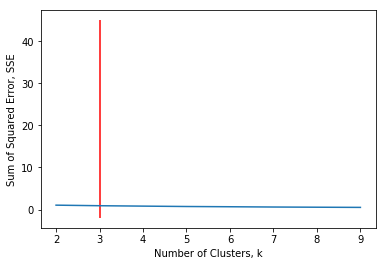

In [169]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# SSE is initialize with empty values
# n_clusters is the "k" 
sse = {}
for n_cluster1 in range(2, 10):
    kmeans1 = KMeans(n_clusters = n_cluster1, max_iter = 500).fit(n_grouped_clustering)
    n_grouped_clustering["clusters"] = kmeans1.labels_
    
    # The inertia is the sum of distances of samples to their closest cluster centre
    sse[n_cluster1] = kmeans1.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters, k")
plt.ylabel("Sum of Squared Error, SSE")
# vertical line
plt.vlines(3, ymin = -2, ymax = 45, colors = 'red')
plt.show()

As we see on the graph, best number of K is 3 for 500 iterations

#### But I'll keep with 4

In [171]:
n_clusters.columns

Index(['Location', 'Borough', 'Postcode', 'Latitude', 'Longitude',
       'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

In [172]:
# Visualization of resulting clusters
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(n_clusters['Latitude'], n_clusters['Longitude'], n_clusters['Location'], n_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

display(map_clusters)

In [174]:
#Cluster 1
n_clusters.loc[n_clusters['Cluster Labels'] == 0, n_clusters.columns[[1] + list(range(4, n_clusters.shape[1]))]]

,Borough,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Haringey,-0.12093,0,Pub,Turkish Restaurant,Café,Coffee Shop,Bakery,Italian Restaurant,Pizza Place,Park,Trail,French Restaurant
21,"Haringey, Islington",-0.09848,0,Café,Pub,Turkish Restaurant,Italian Restaurant,Park,Gym / Fitness Center,Restaurant,Coffee Shop,Pizza Place,Thai Restaurant
36,Haringey,-0.09848,0,Café,Turkish Restaurant,Pub,Coffee Shop,Park,Italian Restaurant,Bakery,Pizza Place,Gym / Fitness Center,Trail
37,Haringey,-0.12093,0,Café,Turkish Restaurant,Pub,Coffee Shop,Park,Italian Restaurant,Bakery,Pizza Place,Gym / Fitness Center,Trail
38,Haringey,-0.07590,0,Café,Turkish Restaurant,Pub,Coffee Shop,Park,Italian Restaurant,Bakery,Pizza Place,Gym / Fitness Center,Trail
40,Islington,-0.09839,0,Café,Pub,Coffee Shop,Turkish Restaurant,Park,Pizza Place,Playground,Bakery,Cocktail Bar,Korean Restaurant
44,Islington,-0.11478,0,Pub,Café,Park,Pizza Place,Coffee Shop,Bar,Italian Restaurant,Bakery,Vietnamese Restaurant,Turkish Restaurant
45,Haringey,-0.12093,0,Pub,Turkish Restaurant,Café,Coffee Shop,Bakery,Italian Restaurant,Pizza Place,Park,Trail,French Restaurant
56,Hackney,-0.09848,0,Café,Pub,Turkish Restaurant,Italian Restaurant,Park,Gym / Fitness Center,Restaurant,Coffee Shop,Pizza Place,Thai Restaurant
59,Islington,-0.11478,0,Pub,Café,Park,Pizza Place,Coffee Shop,Bar,Italian Restaurant,Bakery,Vietnamese Restaurant,Turkish Restaurant


In [177]:
# Cluster 2
n_clusters.loc[n_clusters['Cluster Labels'] == 1, n_clusters.columns[[1] + list(range(4, n_clusters.shape[1]))]]

,Borough,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Brent,-0.25123,1,Grocery Store,Pub,Coffee Shop,Café,Supermarket,Bakery,Pizza Place,Middle Eastern Restaurant,Fast Food Restaurant,Gym / Fitness Center
2,Barnet,-0.19401,1,Grocery Store,Pub,Coffee Shop,Café,Supermarket,Bakery,Pizza Place,Middle Eastern Restaurant,Fast Food Restaurant,Gym / Fitness Center
3,Barnet,-0.24881,1,Coffee Shop,Supermarket,Park,Grocery Store,Gym / Fitness Center,Café,Pub,Asian Restaurant,Pizza Place,Sandwich Place
4,Barnet,-0.13841,1,Pub,Café,Coffee Shop,Grocery Store,Park,Pizza Place,Italian Restaurant,Indian Restaurant,Greek Restaurant,Supermarket
5,Barnet,-0.14852,1,Pub,Café,Coffee Shop,Grocery Store,Park,Pizza Place,Italian Restaurant,Indian Restaurant,Greek Restaurant,Supermarket
7,"Barnet, Brent, Camden",-0.22131,1,Coffee Shop,Grocery Store,Café,Pub,Supermarket,Hotel,Italian Restaurant,Clothing Store,Park,Sushi Restaurant
10,Brent,-0.22131,1,Coffee Shop,Grocery Store,Café,Pub,Supermarket,Hotel,Italian Restaurant,Clothing Store,Park,Sushi Restaurant
11,Barnet,-0.17917,1,Coffee Shop,Grocery Store,Pub,Park,Italian Restaurant,Café,Pharmacy,Pizza Place,Hotel,Golf Course
12,Barnet,-0.24511,1,Coffee Shop,Grocery Store,Pub,Park,Italian Restaurant,Café,Pharmacy,Pizza Place,Hotel,Golf Course
14,Enfield,-0.13841,1,Pub,Grocery Store,Café,Coffee Shop,Park,Pizza Place,Fast Food Restaurant,Italian Restaurant,Greek Restaurant,Fish & Chips Shop


In [178]:
# Cluster 3
n_clusters.loc[n_clusters['Cluster Labels'] == 2, n_clusters.columns[[1] + list(range(4, n_clusters.shape[1]))]]

,Borough,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Barnet,-0.16395,2,Café,Pub,Coffee Shop,Pizza Place,Italian Restaurant,Forest,Gym / Fitness Center,Bakery,Indian Restaurant,French Restaurant
22,Haringey,-0.14852,2,Café,Pub,Coffee Shop,Indian Restaurant,Forest,Italian Restaurant,Pizza Place,Deli / Bodega,Park,Grocery Store
24,Camden,-0.17344,2,Café,Pub,Bakery,Gastropub,Gym / Fitness Center,Bookstore,Park,Museum,History Museum,Pizza Place
26,Camden,-0.13926,2,Pub,Café,Bakery,Gastropub,Pizza Place,Coffee Shop,Bar,Market,Park,Gym / Fitness Center
27,Camden,-0.17344,2,Pub,Café,Bakery,Gastropub,Pizza Place,Coffee Shop,Bar,Market,Park,Gym / Fitness Center
33,Camden,-0.17344,2,Café,Pub,Bakery,Gastropub,Gym / Fitness Center,Bookstore,Park,Museum,History Museum,Pizza Place
34,Barnet,-0.16395,2,Café,Pub,Coffee Shop,Pizza Place,Italian Restaurant,Forest,Gym / Fitness Center,Bakery,Indian Restaurant,French Restaurant
50,Brent,-0.25123,2,Pub,Café,Coffee Shop,Pizza Place,Grocery Store,Middle Eastern Restaurant,Bakery,Indian Restaurant,Italian Restaurant,Park
51,Brent,-0.19778,2,Pub,Café,Coffee Shop,Pizza Place,Grocery Store,Middle Eastern Restaurant,Bakery,Indian Restaurant,Italian Restaurant,Park
53,"Brent, Camden",-0.19778,2,Pub,Café,Pizza Place,Bakery,Gym / Fitness Center,Italian Restaurant,Thai Restaurant,Indian Restaurant,Grocery Store,Coffee Shop


In [179]:
# Cluster 4
n_clusters.loc[n_clusters['Cluster Labels'] == 3, n_clusters.columns[[1] + list(range(4, n_clusters.shape[1]))]]

,Borough,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Islington,-0.09984,3,Pub,Coffee Shop,Café,Cocktail Bar,Theater,Pizza Place,Mediterranean Restaurant,Ice Cream Shop,Trail,Indian Restaurant
6,Islington,-0.12945,3,Pub,Café,Pizza Place,Coffee Shop,Gastropub,Italian Restaurant,Bakery,Japanese Restaurant,Park,Bar
9,Islington,-0.09984,3,Pub,Coffee Shop,Café,Cocktail Bar,Theater,Pizza Place,Mediterranean Restaurant,Ice Cream Shop,Trail,Indian Restaurant
30,Hackney,-0.09984,3,Pub,Café,Coffee Shop,Cocktail Bar,Pizza Place,Turkish Restaurant,Park,Restaurant,Beer Bar,Italian Restaurant
31,Hackney,-0.07313,3,Pub,Café,Coffee Shop,Cocktail Bar,Pizza Place,Turkish Restaurant,Park,Restaurant,Beer Bar,Italian Restaurant
41,Camden,-0.14983,3,Pub,Café,Coffee Shop,Park,Bakery,Pizza Place,Gastropub,Italian Restaurant,Trail,Playground
46,Hackney,-0.09984,3,Pub,Coffee Shop,Café,Cocktail Bar,Theater,Pizza Place,Mediterranean Restaurant,Ice Cream Shop,Trail,Indian Restaurant
48,Islington,-0.09984,3,Pub,Coffee Shop,Café,Cocktail Bar,Theater,Pizza Place,Mediterranean Restaurant,Ice Cream Shop,Trail,Indian Restaurant
49,Islington,-0.09984,3,Pub,Coffee Shop,Café,Cocktail Bar,Theater,Pizza Place,Mediterranean Restaurant,Ice Cream Shop,Trail,Indian Restaurant
52,Camden,-0.13926,3,Pub,Coffee Shop,Bar,Pizza Place,Café,Gastropub,Market,Bakery,Cocktail Bar,Beer Store


### Results section

Outcomes of clustering algorithm:

    1. Pubs, Cafe, Coffee Shops are the top 3 leaders of venues in North London
    2. As for the restaraunts, Turkish and Italian restaraunts are the most popular. Turkish restaraunts, our probable competitors are especially popular in Haringey area.
    3. All areas of North London are considered as good options in terms of oppening Eastern cuisine restaraunts, except Harlingey area, since there are too many Turkish restaraunts.

### Discussion

Cluster 2, 3 and 4 are considered the best for openning the Eastern cuisine restaraunt as there are lack of similar cuisines.
Cluster 1 on the other hand has quite a lot of Turkish restaraunts.

### Conclusion

In conclusion of the project I would say that results have been good, but not that good to use as a basis for decision of openning particular restaraunt.
More data is required, such as demographic data, preferences of people living in the North London area, tourism data etc.

But in a nutshell, very good job has been done.

Thank you all!